In [1]:
%matplotlib inline
import pandas as pd
import swifter
pd.set_option('display.max_rows', 10000)
import seaborn as sns
sns.set(rc={'figure.figsize':(13,13)})

In [2]:
train_articles = pd.read_csv("/data/semeval-2020/task-11/processed/train_article.csv")

In [3]:
span_lables = pd.read_csv("/data/semeval-2020/task-11/processed/span_labels.csv")

In [4]:
span_lables.head()

,article_id,start,end,label
0,776616374,149,174,Exaggeration_Minimisation
1,776616374,751,786,Exaggeration_Minimisation
2,776616374,831,849,Name_Calling_Labeling
3,776616374,2641,2650,Flag-Waving
4,776616374,2771,2782,Loaded_Language


In [5]:
article_with_label = train_articles.merge(span_lables,on="article_id")

In [6]:
def get_span(row):
#     print(row)
    article = row.content
    start_span = row.start
    end_span = row.end
    return article[start_span:end_span]

In [7]:
article_with_label["span"] = article_with_label.swifter.apply(get_span,axis=1)

/home/raghavan/anaconda3/envs/semeval_2020/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [11]:
pd.set_option("display.max_colwidth",4444444)

In [12]:
article_with_label[article_with_label["article_id"] == 111111111]

,article_id,content,start,end,label,span
5897,111111111,"Next plague outbreak in Madagascar could be 'stronger': WHO Geneva - The World Health Organisation chief on Wednesday said a deadly plague epidemic appeared to have been brought under control in Madagascar, but warned the next outbreak would likely be stronger. ""The next transmission could be more pronounced or stronger,"" WHO Director-General Tedros Adhanom Ghebreyesus told reporters in Geneva, insisting that ""the issue is serious."" An outbreak of both bubonic plague, which is spread by infected rats via flea bites, and pneumonic plague, spread person to person, has killed more than 200 people in the Indian Ocean island nation since August. Madagascar has suffered bubonic plague outbreaks almost every year since 1980, often caused by rats fleeing forest fires. The disease tends to make a comeback each hot rainy season, from September to April. On average, between 300 and 600 infections are recorded every year among a population approaching 25 million people, according to a UN estimate. But Tedros voiced alarm that ""plague in Madagascar behaved in a very, very different way this year."" Cases sprang up far earlier than usual and, instead of being confined to the countryside, the disease infiltrated towns. The authorities recorded more than 2 000 cases, and Tedros said Wednesday the death toll stood at 207. He also pointed to the presence of the pneumonic version, which spreads more easily and is more virulent, in the latest outbreak. He praised the rapid response from WHO and Madagascar authorities that helped bring the outbreak under control, but warned that the danger was not over. The larger-than-usual outbreak had helped spread the bacteria that causes the plague more widely. This along with poor sanitation and vector control on Madagascar meant that ""when (the plague) comes again it starts from more stock, and the magnitude in the next transmission could be higher than the one that we saw,"" Tedros said. ""That means that Madagascar could be affected more, and not only that, it could even spill over into neighbouring countries and beyond,"" he warned. Complicating vector control is the fact that the fleas that carry the Yersinia pestis bacteria that causes the plague have proven to be widely resistant to chemicals and insecticides. ""That's a dangerous combination,"" Tedros said.",265,323,Appeal_to_Authority,The next transmission could be more pronounced or stronger
5898,111111111,"Next plague outbreak in Madagascar could be 'stronger': WHO Geneva - The World Health Organisation chief on Wednesday said a deadly plague epidemic appeared to have been brought under control in Madagascar, but warned the next outbreak would likely be stronger. ""The next transmission could be more pronounced or stronger,"" WHO Director-General Tedros Adhanom Ghebreyesus told reporters in Geneva, insisting that ""the issue is serious."" An outbreak of both bubonic plague, which is spread by infected rats via flea bites, and pneumonic plague, spread person to person, has killed more than 200 people in the Indian Ocean island nation since August. Madagascar has suffered bubonic plague outbreaks almost every year since 1980, often caused by rats fleeing forest fires. The disease tends to make a comeback each hot rainy season, from September to April. On average, between 300 and 600 infections are recorded every year among a population approaching 25 million people, according to a UN estimate. But Tedros voiced alarm that ""plague in Madagascar behaved in a very, very different way this year."" Cases sprang up far earlier than usual and, instead of being confined to the countryside, the disease infiltrated towns. The authorities recorded more than 2 000 cases, and Tedros said Wednesday the death toll stood at 207. He also pointed to the presence of the pneumonic version, which spreads more easily and is more virulent, in the latest outbreak. He praised the rapid response from WHO and Mad

In [14]:
article_with_label.to_csv("/data/semeval-2020/task-11/processed/article_with_labels.csv",index=False)

### Sentences per article

In [15]:
article_sentences = pd.DataFrame(article_with_label.groupby("article_id")["content"].first()).reset_index()

In [16]:
article_sentences["num_sentences"] = article_sentences.content.swifter.apply(lambda x: len(x.split(".")))

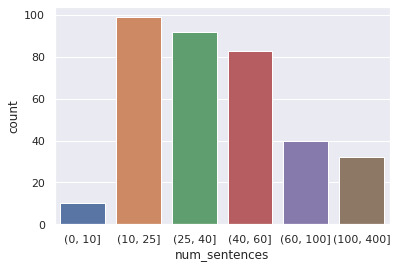

In [17]:
sns.countplot(pd.cut(x=article_sentences.num_sentences,bins=[0,10,25,40,60,100,400]))

### Words per article

In [18]:
article_sentences["num_words"] = article_sentences.content.swifter.apply(lambda x: len(x.split(" ")))

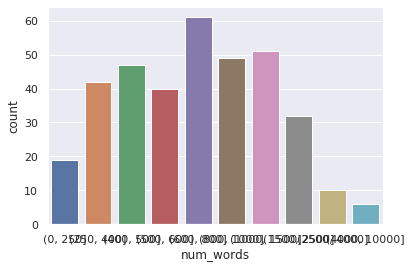

In [19]:
sns.countplot(pd.cut(x=article_sentences.num_words,bins=[0,250,400,500,600,800,1000,1500,2500,4000,10000]))

In [20]:
article_with_label["num_words_per_span"] = article_with_label.span.swifter.apply(lambda x: len(x.split(" ")))

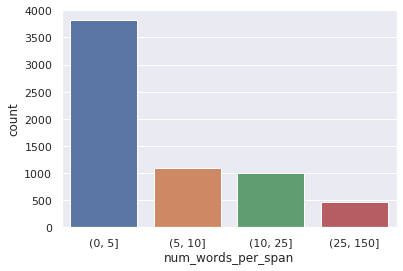

In [21]:
sns.countplot(pd.cut(x=article_with_label.num_words_per_span,bins=[0,5,10,25,150]))

## ^^ Observer the number of words in a span is very less

## Distribution of probaganda labels

In [22]:
article_with_label.label.value_counts()

Loaded_Language                       2200
Name_Calling_Labeling                 1105
Repetition                             621
Doubt                                  496
Exaggeration_Minimisation              493
Appeal_to_fear-prejudice               321
Flag-Waving                            250
Causal_Oversimplification              212
Appeal_to_Authority                    155
Slogans                                138
Black-and-White_Fallacy                112
Whataboutism_Straw_Men_Red_Herring     109
Thought-terminating_Cliches             80
Bandwagon_Reductio_ad_hitlerum          77
Name: label, dtype: int64

## ^^ There is heavy misbalance in classes

## I have a strong intiution that different propaganda classes will have different pos ratios ,Lets check that .

In [27]:
import spacy

In [29]:
nlp = spacy.load('en_core_web_sm')

In [30]:
article_with_label.span[0]

'the worst president in American history'

In [31]:
doc = nlp(article_with_label.span[0])

In [32]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

the the DET DT det xxx True True
worst bad ADJ JJS amod xxxx True False
president president NOUN NN ROOT xxxx True False
in in ADP IN prep xx True True
American american ADJ JJ amod Xxxxx True False
history history NOUN NN pobj xxxx True False


In [38]:
article_with_label["span_pos"] = article_with_label.span.swifter.apply(lambda x: " ".join([token.pos_ for token in nlp(x)]))

/home/raghavan/anaconda3/envs/semeval_2020/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [54]:
pos_by_label = article_with_label.groupby("label")["span_pos"].apply(lambda x:  " ".join(x)).to_frame().reset_index()

In [81]:
from collections import Counter
pos_by_label["pos_counts"] =  pos_by_label.span_pos.swifter.apply(lambda x: Counter(x.split(" ") ))

/home/raghavan/anaconda3/envs/semeval_2020/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [82]:
pos_tag_counts = pos_by_label["pos_counts"].apply(pd.Series)

In [87]:
pos_tag_counts = pos_tag_counts.fillna(0).div(pos_tag_counts.sum(axis=1),axis=0)

In [92]:
pos_tags = ["ADJ","ADP","ADV","CCONJ","DET","INTJ","NOUN","NUM","PART","PRON","PROPN","PUNCT","SPACE","SYM","VERB","X","_"]

In [88]:
pos_by_label[pos_tags] = pos_tag_counts

In [91]:
pos_by_label.head()

,label,span_pos,pos_counts,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SPACE,SYM,VERB,X,_
0,Appeal_to_Authority,ADP DET ADJ NOUN PRON VERB VERB PROPN PROPN PU...,"{'ADP': 479, 'DET': 391, 'ADJ': 337, 'NOUN': 7...",0.121543,0.099213,0.085511,0.179142,0.045674,0.174829,0.094900,0.096676,0.043644,0.027912,0.005329,0.024359,0.000254,0.000507,0.000507,0.000000,0.0
1,Appeal_to_fear-prejudice,DET ADJ NOUN ADP PROPN CCONJ ADJ PUNCT PROPN D...,"{'DET': 572, 'ADJ': 603, 'NOUN': 1048, 'ADP': ...",0.118943,0.096231,0.101447,0.176312,0.045424,0.193472,0.062584,0.077052,0.054677,0.035834,0.006057,0.030451,0.000168,0.000841,0.000168,0.000336,0.0
2,Bandwagon_Reductio_ad_hitlerum,DET ADJ PUNCT ADJ NOUN VERB ADV VERB ADP NOUN ...,"{'DET': 150, 'ADJ': 148, 'PUNCT': 134, 'NOUN':...",0.104426,0.103734,0.102351,0.163900,0.033195,0.160443,0.112033,0.092669,0.061549,0.033887,0.008299,0.019364,0.001383,0.000692,0.001383,0.000692,0.0
3,Black-and-White_Fallacy,NOUN VERB VERB PART VERB ADV ADJ ADV NOUN PUNC...,"{'NOUN': 376, 'VERB': 415, 'PART': 66, 'ADV': ...",0.109283,0.108017,0.079747,0.158650,0.045570,0.175105,0.074684,0.106329,0.063713,0.040928,0.008439,0.027848,0.000422,0.000422,0.000844,0.000000,0.0
4,Causal_Oversimplification,DET VERB ADJ DET NOUN PART VERB PROPN PROPN PA...,"{'DET': 523, 'VERB': 942, 'ADJ': 414, 'NOUN': ...",0.131781,0.103176,0.081673,0.175972,0.053265,0.185835,0.064115,0.077727,0.058591,0.029394,0.006313,0.031564,0.000197,0.000395,0.000000,0.000000,0.0


Text(0.5, 0.98, 'Pie Consumption Patterns in the United States')

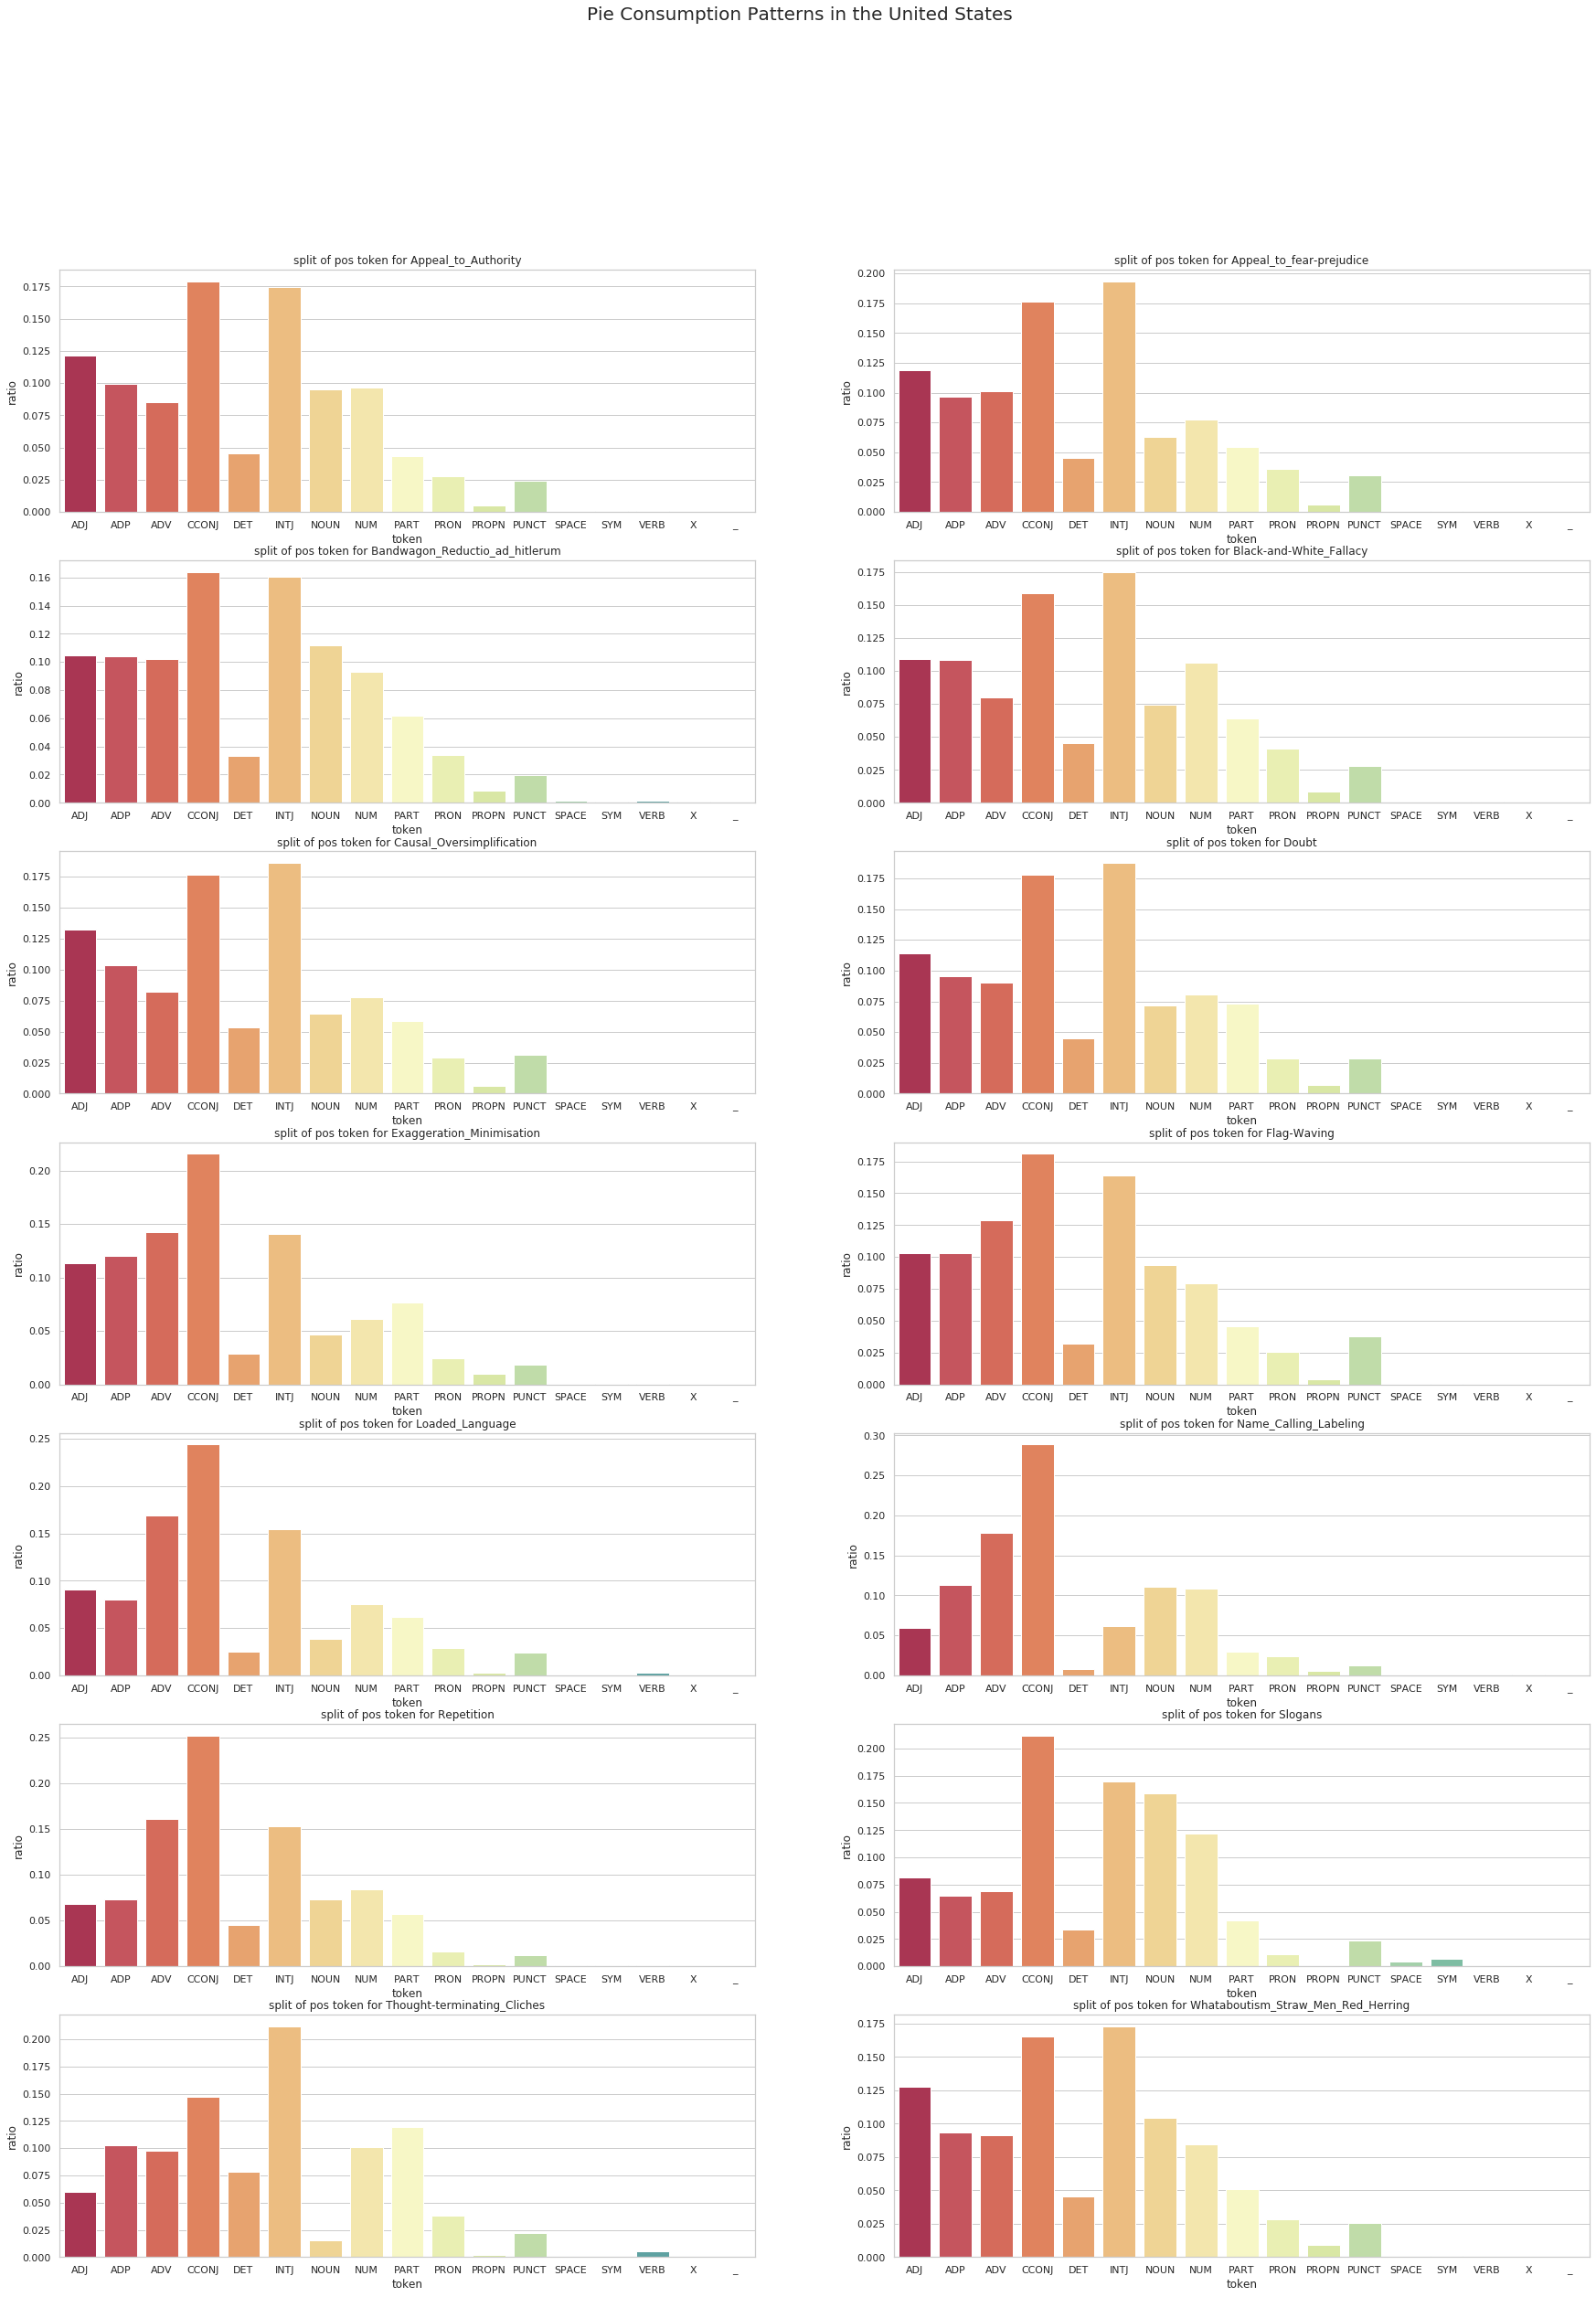

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set(style="whitegrid")
#sns.set_color_codes("Spectral")

plt.figure(10, figsize=(30,40))
the_grid = GridSpec(7, 2)
count_x = 0
count_y = 0

for label in pos_by_label.label.tolist():
    current_label_counts = pos_by_label[pos_by_label["label"] == label][pos_tags]
    show_df= pd.DataFrame({"token":current_label_counts.columns,"ratio":current_label_counts.iloc[0].values})
    plt.subplot(the_grid[count_x, count_y],  title='split of pos token for ' + label)
    sns.barplot(x='token',y='ratio', data=show_df, palette='Spectral')
    if count_y ==1 :
        count_y = 0
        count_x += 1
    else:
        count_y = 1
    
plt.suptitle('Pie Consumption Patterns in the United States', fontsize=20)

## Average number of words per class 

In [133]:
article_with_label.head()

,article_id,content,start,end,label,span,num_words_per_span,span_pos
0,762956953,Iran Admits To Aiding Al-Qaeda and Facilitatin...,630,669,Exaggeration_Minimisation,the worst president in American history,6,DET ADJ NOUN ADP ADJ NOUN
1,787529309,The Last-Minute Character Assassination of Jud...,70,88,Loaded_Language,despicable tactic,3,ADJ NOUN
2,787529309,The Last-Minute Character Assassination of Jud...,288,320,Loaded_Language,have sunk to their lowest level,7,VERB VERB ADP ADJ ADJ NOUN
3,787529309,The Last-Minute Character Assassination of Jud...,924,961,Loaded_Language,categorically and unequivocally deny,5,ADV CCONJ ADV VERB
4,787529309,The Last-Minute Character Assassination of Jud...,2405,2431,Loaded_Language,cesspool of public gossip,5,NOUN ADP ADJ NOUN


In [134]:
article_with_label["phrase_word_count"] = article_with_label["span"].swifter.apply(lambda x:len(x.split(" ")))

/home/raghavan/anaconda3/envs/semeval_2020/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


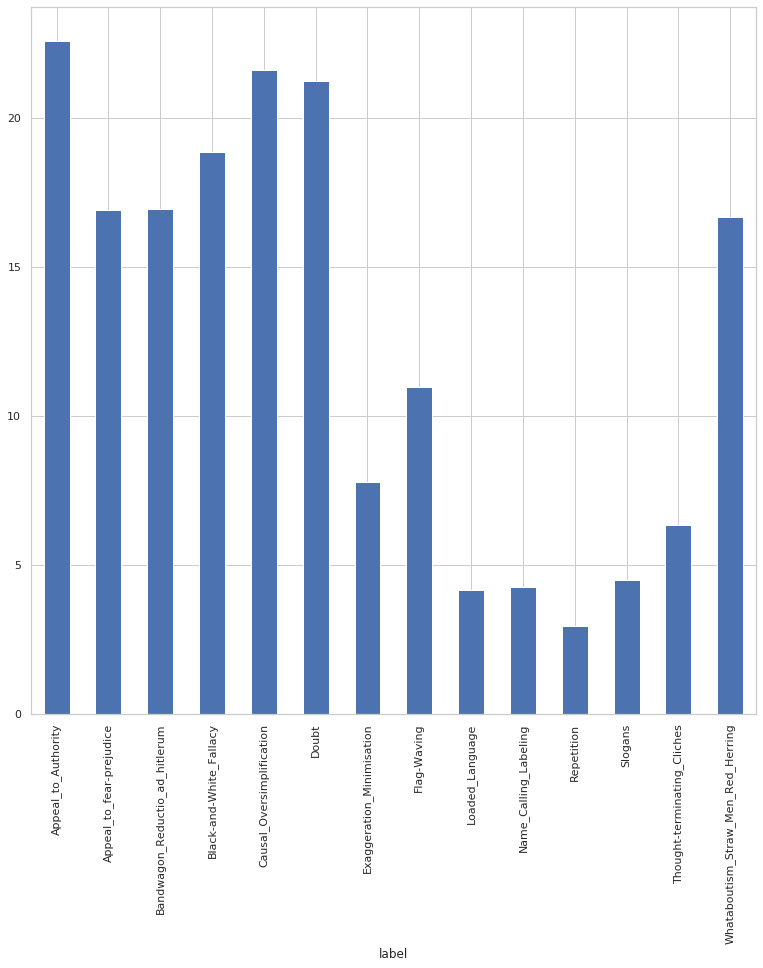

In [138]:
article_with_label.groupby("label")["phrase_word_count"].mean().plot(kind="bar")

## ^^ Some classes seems to have higher word counts than others